# Imports

In [74]:
import numpy as np
import torch.nn.functional as F
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
plt.clf()
plt.close("all")

from scipy.stats import wasserstein_distance

# ordered as [edgecolor, facecolor]
mainblue = ["#42719f", "#6ab4ff"]
coralgreen = ["#117a65", "#138D75"]
reddish = ["#c82929", "#e42f2f"]
orangish = ["#d78939", "#e48a2f"]
blueish = ["#4387cb", "#2f89e4"]

plt.rcParams.update({
        "figure.figsize": [10, 7.5],
        "font.weight": "bold",
        'figure.titlesize': 30,
        'axes.titlesize': 30, # changes the axes titles (figure title when you have only one)
        'figure.titleweight': 'bold',
        "text.usetex": True,
        "font.family": "serif",
        
        'legend.fontsize': 15,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.major.size": 5,
        'xtick.major.width': 1.5,
        "ytick.major.size": 5,
        'ytick.major.width': 1.5,
        "xtick.minor.visible": True,
        "ytick.minor.visible": True,
        "xtick.minor.size": 3,
        'xtick.minor.width': 1.,
        "ytick.minor.size": 3,
        'ytick.minor.width': 1.,
        'axes.labelpad': 25.0,
        #"xtick.major.pad": 7,
        "xtick.labelsize": 30,
        "ytick.labelsize": 30,
        "font.size": 30, # affects axes title size
        "grid.color": "0.5",
        #"grid.linestyle": "-",
        #"grid.linewidth": 5,
        "lines.linewidth": 3,
        #"lines.color": "g",
        })

# Load friend TTrees of real data, and 3-fold reconstructed data

In [75]:
NanoAODSchema.warn_missing_crossrefs = False
j = NanoEventsFactory.from_root( f'../../results/fourTag_10x_picoAOD.root', schemaclass = NanoAODSchema.v7, treepath = 'Events').events().Jet
rec_j = NanoEventsFactory.from_root(  f'../../results/fourTag_10x_dec.root',     schemaclass = NanoAODSchema.v7, treepath = 'Events').events().Jet

Correct $\phi$ to be $\in [-\pi,\ \pi]$

In [76]:
phi_correction = True
def correct_phi(phi): # returns phi values within [-π, π]
    return (phi + np.pi) % (2 * np.pi) - np.pi

mask = ((rec_j.phi > np.pi) | (rec_j.phi < -np.pi))
print("faulty values before correction:", rec_j.phi[mask])
print("faulty values after correction:", correct_phi(rec_j.phi)[mask])
print("\nCorrect values should remain unchanged:")
print(rec_j.phi)
print(correct_phi(rec_j.phi))

rec_j.phi_corrected = correct_phi(rec_j.phi) if phi_correction else rec_j.phi

faulty values before correction: [-4.18, 4.11, 3.97, 4.73, 3.26, -3.81, ... -3.24, -3.19, 3.28, 4.13, 3.16, -3.3]
faulty values after correction: [2.11, -2.17, -2.31, -1.55, -3.02, 2.48, ... 3.04, 3.09, -3, -2.16, -3.13, 2.98]

Correct values should remain unchanged:
[[-1.15, -0.844, -4.18, -3], [-1.17, 1.31, ... -2.73], [3.16, 0.06, -3.3, -0.139]]
[[-1.15, -0.844, 2.11, -3], [-1.17, 1.31, ... -2.73], [-3.13, 0.06, 2.98, -0.139]]


# Several useful functions 

In [77]:
'''
functions to obtain PxPyPzE (and PtEtaPhiM) vectors
'''
def PxPyPzE(j): # need this to be able to add four-vectors
    pt  = j.pt
    eta = j.eta
    phi = j.phi
    m   = j.mass
    
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
    e = np.sqrt(pt**2 + pz**2 + m**2)
    
    j = ak.with_field(j, px, "px")
    j = ak.with_field(j, py, "py")
    j = ak.with_field(j, pz, "pz")
    j = ak.with_field(j, e, "e")
    return j

def PtEtaPhiM(j):
    px = j.px
    py = j.py
    pz = j.pz
    e  = j.e

    pt  = np.sqrt(px**2+py**2)
    ysign = np.sign(py)
    ysign = ysign + np.float64(ysign==0.0) # if py==0, px==Pt and acos(1)=pi/2 so we need zero protection on py.sign()
    phi = np.arccos(px/pt) * ysign
    eta = np.arcsinh(pz/pt)

    m = np.where(e**2 - px**2 - py**2 - pz**2 > 0, np.sqrt(e**2 - px**2 - py**2 - pz**2), 0)

    j = ak.with_field(j, pt, "pt")
    j = ak.with_field(j, eta, "eta")
    j = ak.with_field(j, phi, "phi")
    j = ak.with_field(j, m, "mass")
    return j

'''
Function to hist two variables given the number nbins with the same bin_edges and making sure no bins are empty (useful for computation of residuals)
This is achieved by merging the empty bins with the adjacent ones, eliminating the bin edges where the counts are 0
'''
def merge_empty_bins(var1_to_hist, var2_to_hist, nbins = 32, threshold = 0) -> np.array:
    '''
    Given two variables (var1_to_hist, var2_to_hist) to plot with a number of bins nbins
    returns the bin_edges that ensure that none of the variables have empty histos (and are common to both variables)
    '''

    h_true_possibly_with_zeros, bin_true_edges_possibly_with_zeros = np.histogram(var1_to_hist, bins = nbins)
    h_gen_possibly_with_zeros, bin_gen_edges_possibly_with_zeros = np.histogram(var2_to_hist, bins = bin_true_edges_possibly_with_zeros)
    bin_edges_no_zeros = np.zeros_like(bin_true_edges_possibly_with_zeros)
    to_elim = []
    for i in range(1, len(bin_true_edges_possibly_with_zeros)-1):
        if (h_true_possibly_with_zeros[i] > threshold) and (h_gen_possibly_with_zeros[i] > threshold):
            bin_edges_no_zeros[i] = bin_true_edges_possibly_with_zeros[i]
        else:
            to_elim.append(i)
    bin_edges_no_zeros[0] = bin_true_edges_possibly_with_zeros[0]
    bin_edges_no_zeros[-1] = bin_true_edges_possibly_with_zeros[-1]
    bin_edges_no_zeros = np.delete(bin_edges_no_zeros, to_elim)
    return bin_edges_no_zeros

# Plot PxPyPzE 1D distributions

Obtain the PxPyPzE values

In [78]:
j = PxPyPzE(j)
rec_j = PxPyPzE(rec_j)

## $p_{x}$

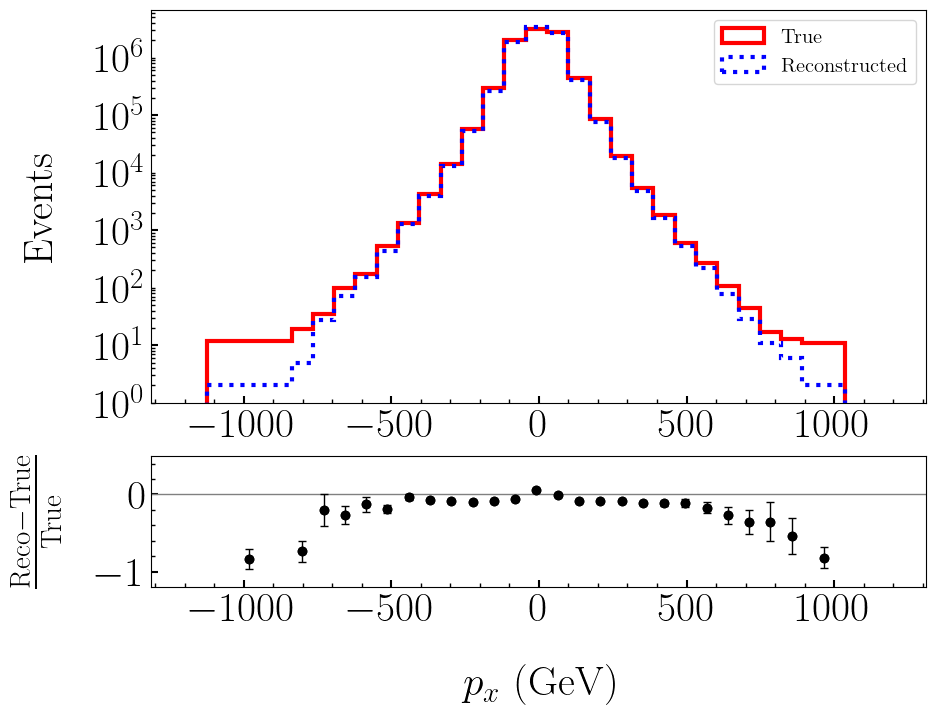

In [81]:
scale_xaxis = 1.75
unc_scale_factor = 1
yres_plot_lim = -1.2, 0.5

true_var_to_hist = ak.flatten(j.px)
rec_var_to_hist = ak.flatten(rec_j.px)

max = 750
min = -max
width = 50 # GeV
nbins = int(round((max - min) / width))

bins = merge_empty_bins(true_var_to_hist, rec_var_to_hist, nbins, threshold = 1)

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
# data
h_true, bins_true, _true = ax1.hist(
    true_var_to_hist,
    bins = bins,
    histtype = "step",
    lw = plt.rcParams["lines.linewidth"],
    color = "red",
    label = r"True"
)
h_rec, bins_rec, _rec = ax1.hist(
    rec_var_to_hist,
    bins = bins,
    histtype = "step",
    lw = plt.rcParams["lines.linewidth"],
    color = "blue",
    ls = 'dotted',
    label = r"Reconstructed"
)
# residuals
bins_center = 0.5 * (bins_true[1:] + bins_true[:-1])

# subtraction
residuals = (h_rec-h_true)/h_true
residuals_error = np.sqrt( (h_rec / h_true**2)**2 * h_true    +   1/h_true**2*h_rec)

# fraction
#residuals = h_rec / h_true
#residuals_error = h_rec / h_true * np.sqrt(1 / h_rec + 1 / h_true)

residuals_mean = np.mean(residuals)
residuals_std = np.std(residuals)
ylim_min, ylim_max = residuals_mean - 3 * residuals_std, residuals_mean + 3 * residuals_std

'''

# Plot arrows for points beyond the limits
for i, res in enumerate(residuals):
    if res > ylim_max or res < ylim_min:
        direction = ylim_max if res > ylim_max else ylim_min
        ax2.arrow(bins_center[i], 0.5*direction, 0, (1-0.75)*direction, head_width=(bins_center[1]-bins_center[0])*0.5, head_length=0.1*(ylim_max-ylim_min), fc='black', ec='black', lw=1, alpha=1, linestyle='solid')
'''

ax2.axhline(0, color='gray', lw = 1, linestyle='-')
ax2.plot(bins_center, residuals, marker='o', lw = 0, color="black")
ax2.errorbar(bins_center, residuals, yerr = unc_scale_factor * residuals_error, fmt = "o", capsize = 3., elinewidth = 1., lw = 0, color = "black")
#ax2.errorbar(bins_center, residuals, xerr = 0.5*(bins_true[1:] - bins_true[:-1]), fmt = "o", capsize = 0., elinewidth = 1., lw = 0, color = "black")

# format
#ax1.set_xscale('symlog', linthresh=100); ax1.axvline(x = 100, ls = 'dashed', color = 'gray', alpha = 0.7); ax1.axvline(x = -100, ls = 'dashed', color = 'gray', alpha = 0.7)
ax1.set_yscale("log")
ax1.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=10))
ax1.set_ylabel('Events')
ax1.set_xlim(min*scale_xaxis, max*scale_xaxis)
ax1.legend(loc = "best")

#ax2.set_xscale('symlog', linthresh=100); ax2.axvline(x = 100, ls = 'dashed', color = 'gray', alpha = 0.7); ax2.axvline(x = -100, ls = 'dashed', color = 'gray', alpha = 0.7)
# Create a FixedLocator for the linear region
#linear_locator = ticker.FixedLocator([-15000, -1e3, 0, 1e3, 15000])
#ax2.yaxis.set_major_locator(linear_locator)
# Create a LogLocator for the logarithmic region
#log_locator = ticker.LogLocator(base=10.0, subs=(1.0, 5.0), numticks=2)
#ax2.yaxis.set_minor_locator(log_locator)
# Format the tick labels to display in scientific notation for the logarithmic region
#ax2.yaxis.set_major_formatter(ticker.ScalarFormatter())

ax2.set_xlabel("$p_{x}\ ({\mathrm{GeV}})$")
ax2.set_ylabel("$\\frac{{\\rm Reco} - {\\rm True}}{{\\rm True}}$")
ax2.set_xlim(min*scale_xaxis, max*scale_xaxis)
yres_plot_lim = (ylim_min, ylim_max) if yres_plot_lim is None else yres_plot_lim
ax2.set_ylim(yres_plot_lim)
fig.savefig("../../plots/results/px.pdf", bbox_inches='tight')

## $E$

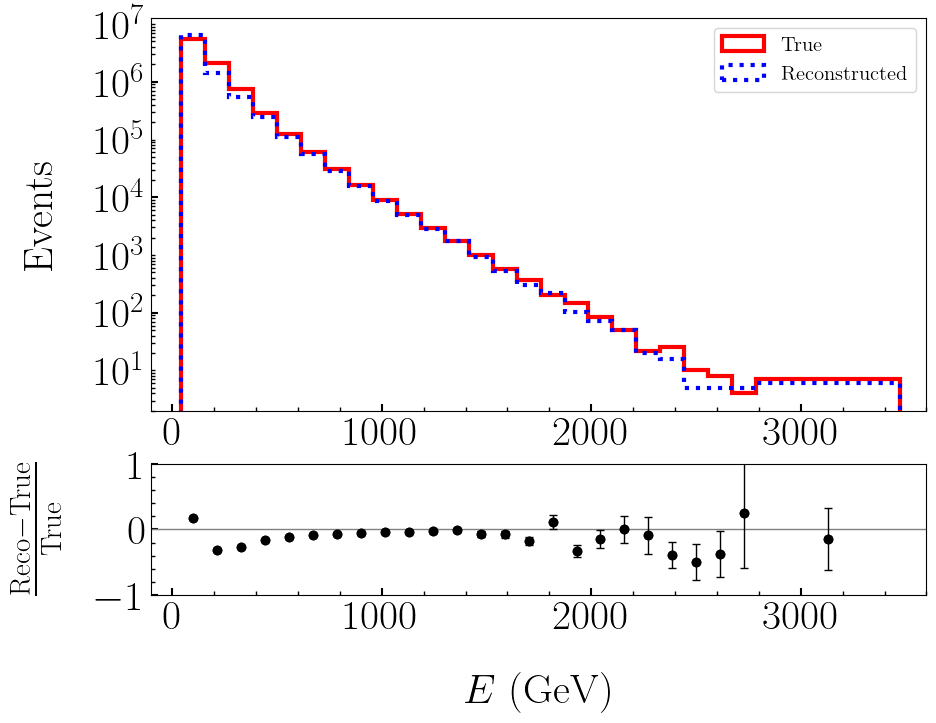

In [105]:
scale_xaxis = 1.2
unc_scale_factor = 1
yres_plot_lim = -1, 1

true_var_to_hist = ak.flatten(j.e)
rec_var_to_hist = ak.flatten(rec_j.e)

max = 3000
min = 0
width = 100 # GeV
nbins = int(round((max - min) / width))

bins = merge_empty_bins(true_var_to_hist, rec_var_to_hist, nbins, threshold = 1)

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
# data
h_true, bins_true, _true = ax1.hist(
    true_var_to_hist,
    bins = bins,
    histtype = "step",
    lw = plt.rcParams["lines.linewidth"],
    color = "red",
    label = r"True"
)
h_rec, bins_rec, _rec = ax1.hist(
    rec_var_to_hist,
    bins = bins,
    histtype = "step",
    lw = plt.rcParams["lines.linewidth"],
    color = "blue",
    ls = 'dotted',
    label = r"Reconstructed"
)
# residuals
bins_center = 0.5 * (bins_true[1:] + bins_true[:-1])

# subtraction
residuals = (h_rec - h_true)/h_true
residuals_error = np.sqrt( (h_rec / h_true**2)**2 * h_true    +   1/h_true**2*h_rec)

# fraction
#residuals = h_rec / h_true
#residuals_error = h_rec / h_true * np.sqrt(1 / h_rec + 1 / h_true)

residuals_mean = np.mean(residuals)
residuals_std = np.std(residuals)
ylim_min, ylim_max = residuals_mean - 3 * residuals_std, residuals_mean + 3 * residuals_std

'''

# Plot arrows for points beyond the limits
for i, res in enumerate(residuals):
    if res > ylim_max or res < ylim_min:
        direction = ylim_max if res > ylim_max else ylim_min
        ax2.arrow(bins_center[i], 0.5*direction, 0, (1-0.75)*direction, head_width=(bins_center[1]-bins_center[0])*0.5, head_length=0.1*(ylim_max-ylim_min), fc='black', ec='black', lw=1, alpha=1, linestyle='solid')
'''

ax2.axhline(0, color='gray', lw = 1, linestyle='-')
ax2.plot(bins_center, residuals, marker='o', lw = 0, color="black")
ax2.errorbar(bins_center, residuals, yerr = unc_scale_factor * residuals_error, fmt = "o", capsize = 3., elinewidth = 1., lw = 0, color = "black")
#ax2.errorbar(bins_center, residuals, xerr = 0.5*(bins_true[1:] - bins_true[:-1]), fmt = "o", capsize = 0., elinewidth = 1., lw = 0, color = "black")

# format
#ax1.set_xscale('symlog', linthresh=100); ax1.axvline(x = 100, ls = 'dashed', color = 'gray', alpha = 0.7); ax1.axvline(x = -100, ls = 'dashed', color = 'gray', alpha = 0.7)
ax1.set_yscale("log")
ax1.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9), numticks=10))
ax1.set_ylabel('Events')
ax1.set_xlim(-100, max*scale_xaxis)
ax1.legend(loc = "best")

#ax2.set_xscale('symlog', linthresh=100); ax2.axvline(x = 100, ls = 'dashed', color = 'gray', alpha = 0.7); ax2.axvline(x = -100, ls = 'dashed', color = 'gray', alpha = 0.7)
# Create a FixedLocator for the linear region
#linear_locator = ticker.FixedLocator([-15000, -1e3, 0, 1e3, 15000])
#ax2.yaxis.set_major_locator(linear_locator)
# Create a LogLocator for the logarithmic region
#log_locator = ticker.LogLocator(base=10.0, subs=(1.0, 5.0), numticks=2)
#ax2.yaxis.set_minor_locator(log_locator)
# Format the tick labels to display in scientific notation for the logarithmic region
#ax2.yaxis.set_major_formatter(ticker.ScalarFormatter())

ax2.set_xlabel("$E\ ({\mathrm{GeV}})$")
ax2.set_ylabel("$\\frac{{\\rm Reco} - {\\rm True}}{{\\rm True}}$")
ax2.set_xlim(-100, max*scale_xaxis)
yres_plot_lim = (ylim_min, ylim_max) if yres_plot_lim is None else yres_plot_lim
ax2.set_ylim(yres_plot_lim)
fig.savefig("../../plots/results/E_rec.pdf", bbox_inches='tight')

In [83]:
wasserstein_distance(ak.flatten(j.E), ak.flatten(rec_j.E))

18.8171003759825

# Plot PtEtaPhiM 1D distributions


# Plot $m_{2j}$ vs $m_{4j}$

In [84]:
'''
Obtain dijets
'''
d = ak.zip({    "px" : j.px[:,(0,2,0,1,0,1)]+j.px[:,(1,3,2,3,3,2)],
                "py" : j.py[:,(0,2,0,1,0,1)]+j.py[:,(1,3,2,3,3,2)], 
                "pz" : j.pz[:,(0,2,0,1,0,1)]+j.pz[:,(1,3,2,3,3,2)],
                "e"  : j. e[:,(0,2,0,1,0,1)]+j. e[:,(1,3,2,3,3,2)]})
d = PtEtaPhiM(d) # obtain PtEtaPhiM fields

rec_d = ak.zip({    "px" : rec_j.px[:,(0,2,0,1,0,1)]+rec_j.px[:,(1,3,2,3,3,2)],
                    "py" : rec_j.py[:,(0,2,0,1,0,1)]+rec_j.py[:,(1,3,2,3,3,2)], 
                    "pz" : rec_j.pz[:,(0,2,0,1,0,1)]+rec_j.pz[:,(1,3,2,3,3,2)],
                    "e"  : rec_j. e[:,(0,2,0,1,0,1)]+rec_j. e[:,(1,3,2,3,3,2)]})
rec_d = PtEtaPhiM(rec_d) # obtain PtEtaPhiM fields

'''
Obtain quadjets
'''
q = ak.zip({    "px" : d.px[:,(0,2,4,0,2,4)]+d.px[:,(1,3,5,1,3,5)],
                "py" : d.py[:,(0,2,4,0,2,4)]+d.py[:,(1,3,5,1,3,5)], 
                "pz" : d.pz[:,(0,2,4,0,2,4)]+d.pz[:,(1,3,5,1,3,5)],
                "e"  : d. e[:,(0,2,4,0,2,4)]+d. e[:,(1,3,5,1,3,5)]})
q = PtEtaPhiM(q) # obtain PtEtaPhiM fields

rec_q = ak.zip({    "px" : rec_d.px[:,(0,2,4,0,2,4)]+rec_d.px[:,(1,3,5,1,3,5)],
                    "py" : rec_d.py[:,(0,2,4,0,2,4)]+rec_d.py[:,(1,3,5,1,3,5)], 
                    "pz" : rec_d.pz[:,(0,2,4,0,2,4)]+rec_d.pz[:,(1,3,5,1,3,5)],
                    "e"  : rec_d. e[:,(0,2,4,0,2,4)]+rec_d. e[:,(1,3,5,1,3,5)]})
rec_q = PtEtaPhiM(rec_q) # obtain PtEtaPhiM fields

In [114]:
m4j_plot_limits = (-200, 5400)
m2j_plot_limits = (-200, 4000)
width_m4j = 220
width_m2j = 210

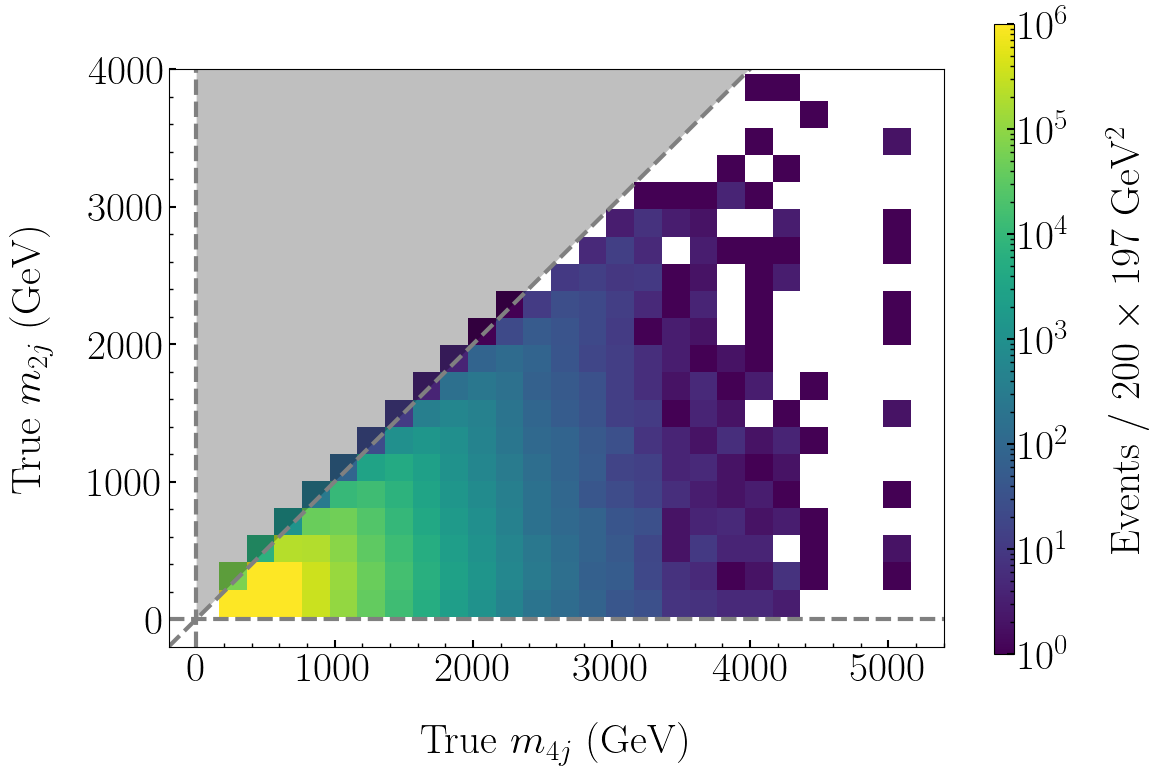

In [117]:
fig, ax = plt.subplots(1)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.84])
cmap = cm.get_cmap("viridis") # cmap = cm.get_cmap("bwr")
bin_nb = (int(round((m4j_plot_limits[1]-m4j_plot_limits[0])/width_m4j)), int(round((m2j_plot_limits[1]-m2j_plot_limits[0])/width_m2j)))

h2d_true, xbins_true, ybins_true, im_true = ax.hist2d(
    ak.to_numpy(ak.flatten(q.mass)),
    ak.to_numpy(ak.flatten(d.mass)),
    bins = bin_nb,
    cmap=cmap,
    norm = matplotlib.colors.LogNorm(vmax = 1000000)
)
cbar = fig.colorbar(im_true, cax=cbar_ax)
cbar.set_label(f'Events / {xbins_true[1]- xbins_true[0]:.0f} $\\times$ {ybins_true[1]- ybins_true[0]:.0f} GeV$^2$')

ax.set_xlabel('True $m_{4j}\ ({\mathrm{GeV}})$')
ax.set_ylabel('True $m_{2j}\ ({\mathrm{GeV}})$')

# rather fancy stuff
x = np.linspace(*m4j_plot_limits, 1000)
ax.plot(x, x, color = "gray", ls = "dashed")
ax.fill_between(x, x, 1e6*x, where = (x>0), facecolor='black', alpha = 0.25)


ax.axhline(0, color = "gray", ls = 'dashed')
ax.axvline(0, color = "gray", ls = 'dashed')
ax.set_xlim(m4j_plot_limits)
ax.set_ylim(m2j_plot_limits)
fig.savefig("../../plots/results/m2j_m4j_true.pdf", bbox_inches='tight')

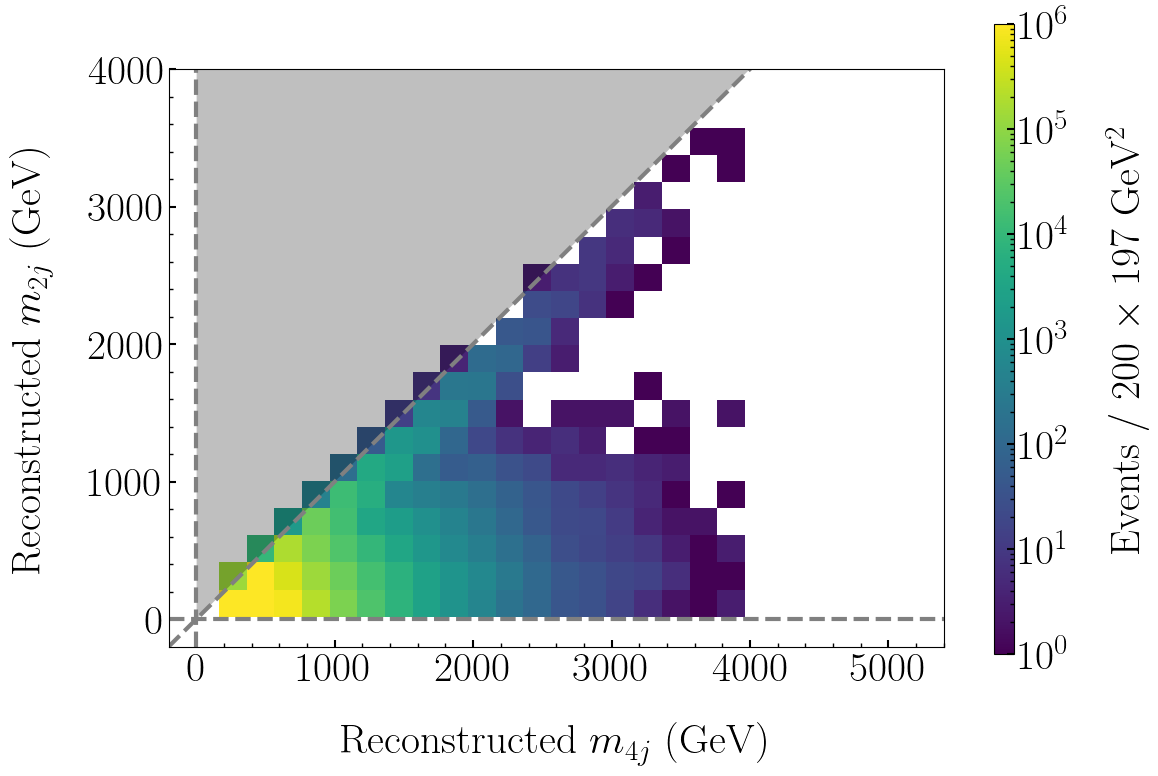

In [118]:
fig, ax = plt.subplots(1)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.84])
cmap = cm.get_cmap("viridis") # cmap = cm.get_cmap("bwr")

h2d_rec, xbins_rec, ybins_rec, im_rec = ax.hist2d(
    ak.to_numpy(ak.flatten(rec_q.mass)),
    ak.to_numpy(ak.flatten(rec_d.mass)),
    bins = [xbins_true, ybins_true],
    cmap=cmap,
    norm = matplotlib.colors.LogNorm(vmax = 1000000)
)
cbar = fig.colorbar(im_rec, cax=cbar_ax)
cbar.set_label(f'Events / {xbins_rec[1]- xbins_rec[0]:.0f} $\\times$ {ybins_rec[1]- ybins_rec[0]:.0f} GeV$^2$')

ax.set_xlabel('Reconstructed $m_{4j}\ ({\mathrm{GeV}})$')
ax.set_ylabel('Reconstructed $m_{2j}\ ({\mathrm{GeV}})$')

# rather fancy stuff
x = np.linspace(*m4j_plot_limits, 1000)
ax.plot(x, x, color = "gray", ls = "dashed")
ax.fill_between(x, x, 1e6*x, where = (x>0), facecolor='black', alpha = 0.25)


ax.axhline(0, color = "gray", ls = 'dashed')
ax.axvline(0, color = "gray", ls = 'dashed')
ax.set_xlim(m4j_plot_limits)
ax.set_ylim(m2j_plot_limits)
fig.savefig("../../plots/results/m2j_m4j_rec.pdf", bbox_inches='tight')

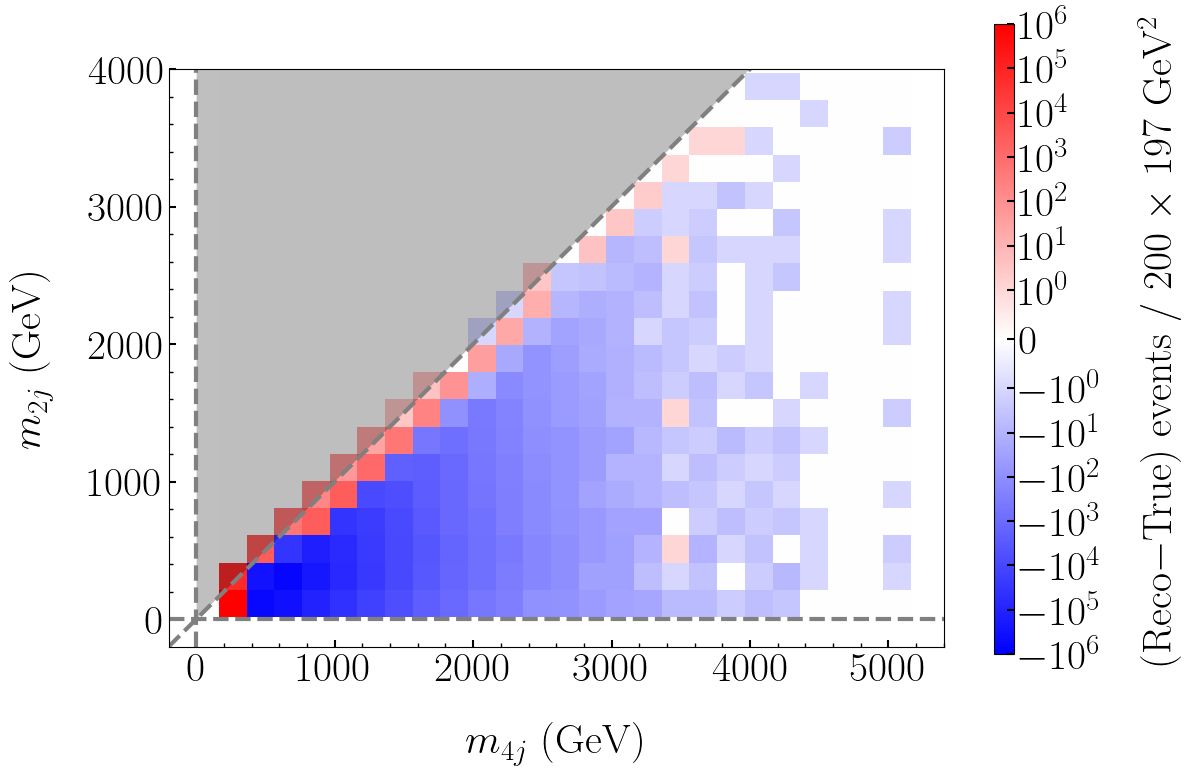

In [119]:
fig, ax = plt.subplots(1)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.84])
cmap = cm.get_cmap("bwr")

h2d_diff =  h2d_rec - h2d_true

im = ax.imshow(
    h2d_diff.T,
    origin='lower',
    extent=[xbins_true.min(), xbins_true.max(), ybins_true.min(), ybins_true.max()],
    cmap=cmap,
    aspect = 'auto',
    #interpolation = 'antialiased',
    #vmax = 10000, vmin = -10000,
    norm = matplotlib.colors.SymLogNorm(linthresh = 1, vmax = 1e6, vmin = -1e6)
)
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(f'(Reco$-$True) events / {xbins_true[1]- xbins_true[0]:.0f} $\\times$ {ybins_true[1]- ybins_true[0]:.0f} GeV$^2$')


ax.set_xlabel('$m_{4j}\ ({\mathrm{GeV}})$')
ax.set_ylabel('$m_{2j}\ ({\mathrm{GeV}})$')

# rather fancy stuff
x = np.linspace(*m4j_plot_limits, 1000)
ax.plot(x, x, color = "gray", ls = "dashed")
ax.fill_between(x, x, 1e6*x, where = (x>0), facecolor='black', alpha = 0.25)


ax.axhline(0, color = "gray", ls = 'dashed')
ax.axvline(0, color = "gray", ls = 'dashed')
ax.set_xlim(m4j_plot_limits)
ax.set_ylim(m2j_plot_limits)
fig.savefig(f"../../plots/results/m2j_m4j_recdiff.pdf", bbox_inches='tight')

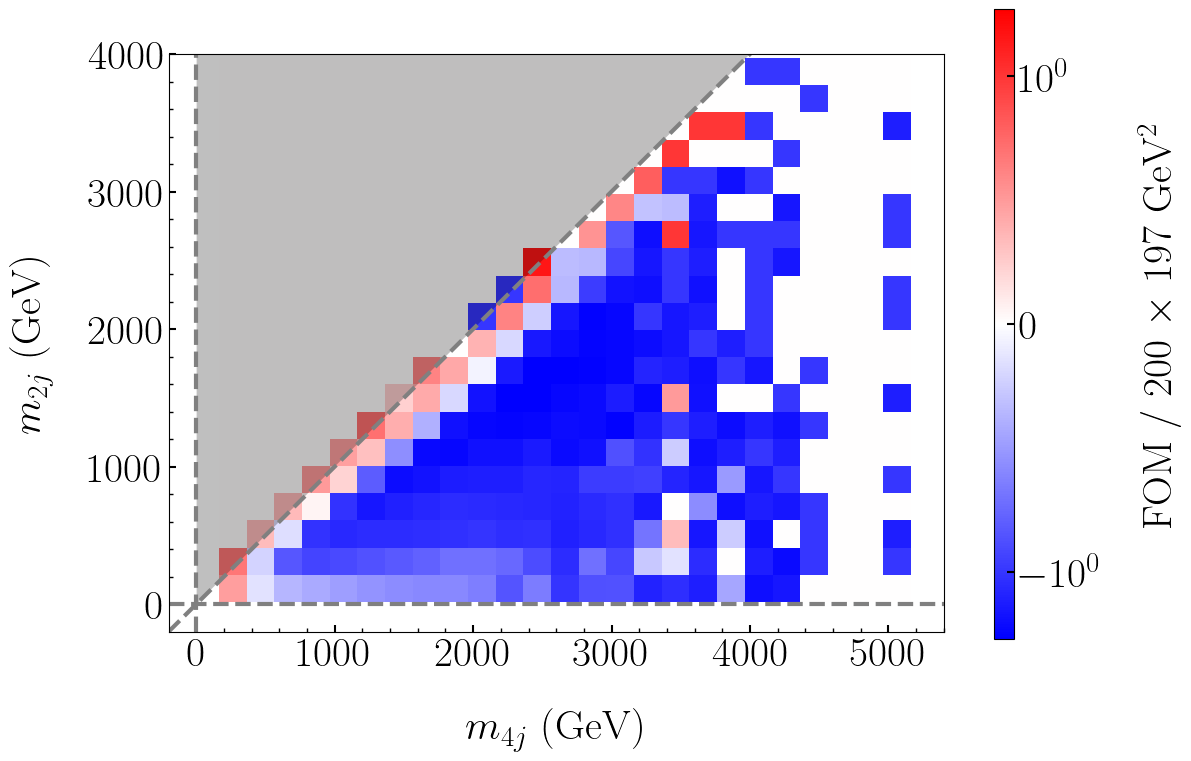

In [127]:
fig, ax = plt.subplots(1)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.84])
cmap = cm.get_cmap("bwr")


denom = np.sqrt(h2d_true + h2d_rec)
FOM = np.divide(h2d_diff, denom, out = np.zeros_like(h2d_diff), where=denom!=0)
FOM2 = (h2d_rec-h2d_true) * 2 / (h2d_rec+h2d_true+1)
im = ax.imshow(
    FOM2.T,
    origin='lower',
    extent=[xbins_true.min(), xbins_true.max(), ybins_true.min(), ybins_true.max()],
    cmap=cmap,
    aspect = 'auto',
    #interpolation = 'antialiased',
    #vmax = 10000, vmin = -10000,
    norm = matplotlib.colors.SymLogNorm(linthresh = 1, vmax = 2, vmin = -2)
)
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(f'FOM / {xbins_true[1]- xbins_true[0]:.0f} $\\times$ {ybins_true[1]- ybins_true[0]:.0f} GeV$^2$')


ax.set_xlabel('$m_{4j}\ ({\mathrm{GeV}})$')
ax.set_ylabel('$m_{2j}\ ({\mathrm{GeV}})$')

# rather fancy stuff
x = np.linspace(*m4j_plot_limits, 1000)
ax.plot(x, x, color = "gray", ls = "dashed")
ax.fill_between(x, x, 1e6*x, where = (x>0), facecolor='black', alpha = 0.25)

#### percentual difference

ax.axhline(0, color = "gray", ls = 'dashed')
ax.axvline(0, color = "gray", ls = 'dashed')
ax.set_xlim(m4j_plot_limits)
ax.set_ylim(m2j_plot_limits)
fig.savefig(f"../../plots/results/m2j_m4j_recFOM2.pdf", bbox_inches='tight')

In [102]:
print("Sum of all the FOMs dividing by the total number of bins:")
print("FOM:", np.sum(FOM))
print("bins:", np.sum(np.shape(FOM)))
print("FOM/bins:", np.sum(FOM)/np.sum(np.shape(FOM)))
print("I guess this could be interpreted as the average deviation of events in each bin")

Sum of all the FOMs dividing by the total number of bins:
FOM: -34360.12315585373
bins: 455
FOM/bins: -75.51675418868952
I guess this could be interpreted as the average deviation of events in each bin


In [388]:
'''
fig, ax = plt.subplots(1)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.84])
cmap = cm.get_cmap("viridis") # cmap = cm.get_cmap("bwr")
bin_nb = (int(round((m2j_plot_limits[1]-m2j_plot_limits[0])/width_m2j)), int(round((m4j_plot_limits[1]-m4j_plot_limits[0])/width_m4j)))

h2d_true, xbins_true, ybins_true, im_true = ax.hist2d(
    ak.to_numpy(ak.flatten(d.mass)),
    ak.to_numpy(ak.flatten(q.mass)),
    bins = bin_nb,
    cmap=cmap,
    norm = matplotlib.colors.LogNorm(vmax = 1000000)
)
cbar = fig.colorbar(im_true, cax=cbar_ax)
cbar.set_label(f'Events / {xbins_true[1]- xbins_true[0]:.0f} $\\times$ {ybins_true[1]- ybins_true[0]:.0f} GeV$^2$')

ax.set_xlabel('True $m_{2j}\ ({\mathrm{GeV}})$')
ax.set_ylabel('True $m_{4j}\ ({\mathrm{GeV}})$')

# rather fancy stuff
x = np.linspace(*m2j_plot_limits, 1000)
ax.plot(x, x, color = "gray", ls = "dashed")
ax.fill_between(x, x, 0, where = (x>0), facecolor='black', alpha = 0.25)
ax.text(x = (m2j_plot_limits[1]-m2j_plot_limits[0])*0.5, y = (m4j_plot_limits[1]-m4j_plot_limits[0])*0.04, s = "Non-conserved mass", fontweight = 'bold')

ax.axhline(0, color = "gray", ls = 'dashed')
ax.axvline(0, color = "gray", ls = 'dashed')
ax.set_xlim(m2j_plot_limits)
ax.set_ylim(m4j_plot_limits)
fig.savefig("../../plots/results/m4j_m2j_true.pdf", bbox_inches='tight')




###########################################################################################################################################################################




fig, ax = plt.subplots(1)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.84])
cmap = cm.get_cmap("viridis") # cmap = cm.get_cmap("bwr")

h2d_rec, xbins_rec, ybins_rec, im_rec = ax.hist2d(
    ak.to_numpy(ak.flatten(d.mass)),
    ak.to_numpy(ak.flatten(rec_q.mass)),
    bins = [xbins_true, ybins_true],
    cmap=cmap,
    norm = matplotlib.colors.LogNorm(vmax = 1000000)
)
cbar = fig.colorbar(im_true, cax=cbar_ax)
cbar.set_label(f'Events / {xbins_rec[1]- xbins_rec[0]:.0f} $\\times$ {ybins_rec[1]- ybins_rec[0]:.0f} GeV$^2$')

ax.set_xlabel('True $m_{2j}\ ({\mathrm{GeV}})$')
ax.set_ylabel('Reconstructed $m_{4j}\ ({\mathrm{GeV}})$')

# rather fancy stuff
x = np.linspace(*m2j_plot_limits, 1000)
ax.plot(x, x, color = "gray", ls = "dashed")
ax.fill_between(x, x, 0, where = (x>0), facecolor='black', alpha = 0.25)
ax.text(x = (m2j_plot_limits[1]-m2j_plot_limits[0])*0.5, y = (m4j_plot_limits[1]-m4j_plot_limits[0])*0.04, s = "Non-conserved mass", fontweight = 'bold')

ax.axhline(0, color = "gray", ls = 'dashed')
ax.axvline(0, color = "gray", ls = 'dashed')
ax.set_xlim(m2j_plot_limits)
ax.set_ylim(m4j_plot_limits)
fig.savefig("../../plots/results/m4j_m2j_rec.pdf", bbox_inches='tight')




###########################################################################################################################################################################




fig, ax = plt.subplots(1)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.84])
cmap = cm.get_cmap("bwr")


h2d_diff = h2d_true - h2d_rec
im = ax.imshow(
    h2d_diff.T,
    origin='lower',
    extent=[xbins_true.min(), xbins_true.max(), ybins_true.min(), ybins_true.max()],
    cmap=cmap,
    aspect = 'auto',
    #interpolation = 'antialiased',
    #vmax = 10000, vmin = -10000,
    norm = matplotlib.colors.SymLogNorm(linthresh = 1, vmax = 10000, vmin = -10000)
)
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(f'Events / {xbins_true[1]- xbins_true[0]:.0f} $\\times$ {ybins_true[1]- ybins_true[0]:.0f} GeV$^2$')

ax.set_xlabel('True $m_{2j}\ ({\mathrm{GeV}})$')
ax.set_ylabel('True - reconstructed $m_{4j}\ ({\mathrm{GeV}})$')

# rather fancy stuff
x = np.linspace(*m2j_plot_limits, 1000)
ax.plot(x, x, color = "gray", ls = "dashed")
ax.fill_between(x, x, 0, where = (x>0), facecolor='black', alpha = 0.25)
ax.text(x = (m2j_plot_limits[1]-m2j_plot_limits[0])*0.5, y = (m4j_plot_limits[1]-m4j_plot_limits[0])*0.04, s = "Non-conserved mass", fontweight = 'bold')

ax.axhline(0, color = "gray", ls = 'dashed')
ax.axvline(0, color = "gray", ls = 'dashed')
ax.set_xlim(m2j_plot_limits)
ax.set_ylim(m4j_plot_limits)
fig.savefig(f"../../plots/results/m4j_m2j_recdiff.pdf", bbox_inches='tight')




fig, ax = plt.subplots(1)
cbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.84])
cmap = cm.get_cmap("viridis") # cmap = cm.get_cmap("bwr")
bin_nb = (int(round((m4j_plot_limits[1]-m4j_plot_limits[0])/width_m4j)), int(round((m2j_plot_limits[1]-m2j_plot_limits[0])/width_m2j)))

h2d_rec, xbins_rec, ybins_rec, im_rec = ax.hist2d(
    ak.to_numpy(ak.flatten(rec_q.mass)),
    ak.to_numpy(ak.flatten(rec_d.mass)),
    bins = bin_nb,
    cmap=cmap,
    norm = matplotlib.colors.LogNorm(vmax = 1000000)
)
cbar = fig.colorbar(im_rec, cax=cbar_ax)
cbar.set_label(f'Events / {xbins_rec[1]- xbins_rec[0]:.0f} $\\times$ {ybins_rec[1]- ybins_rec[0]:.0f} GeV$^2$')

ax.set_xlabel('Reconstructed $m_{4j}\ ({\mathrm{GeV}})$')
ax.set_ylabel('Reconstructed $m_{2j}\ ({\mathrm{GeV}})$')

# rather fancy stuff
x = np.linspace(*m4j_plot_limits, 1000)
ax.plot(x, x, color = "gray", ls = "dashed")
ax.fill_between(x, x, 1e6*x, where = (x>0), facecolor='black', alpha = 0.25)


ax.axhline(0, color = "gray", ls = 'dashed')
ax.axvline(0, color = "gray", ls = 'dashed')
ax.set_xlim(m4j_plot_limits)
ax.set_ylim(m2j_plot_limits)
fig.savefig("../../plots/results/m2j_m4j_both_rec.pdf", bbox_inches='tight')
'''

'\nfig, ax = plt.subplots(1)\ncbar_ax = fig.add_axes([0.95, 0.1, 0.02, 0.84])\ncmap = cm.get_cmap("viridis") # cmap = cm.get_cmap("bwr")\nbin_nb = (int(round((m2j_plot_limits[1]-m2j_plot_limits[0])/width_m2j)), int(round((m4j_plot_limits[1]-m4j_plot_limits[0])/width_m4j)))\n\nh2d_true, xbins_true, ybins_true, im_true = ax.hist2d(\n    ak.to_numpy(ak.flatten(d.mass)),\n    ak.to_numpy(ak.flatten(q.mass)),\n    bins = bin_nb,\n    cmap=cmap,\n    norm = matplotlib.colors.LogNorm(vmax = 1000000)\n)\ncbar = fig.colorbar(im_true, cax=cbar_ax)\ncbar.set_label(f\'Events / {xbins_true[1]- xbins_true[0]:.0f} $\\times$ {ybins_true[1]- ybins_true[0]:.0f} GeV$^2$\')\n\nax.set_xlabel(\'True $m_{2j}\\ ({\\mathrm{GeV}})$\')\nax.set_ylabel(\'True $m_{4j}\\ ({\\mathrm{GeV}})$\')\n\n# rather fancy stuff\nx = np.linspace(*m2j_plot_limits, 1000)\nax.plot(x, x, color = "gray", ls = "dashed")\nax.fill_between(x, x, 0, where = (x>0), facecolor=\'black\', alpha = 0.25)\nax.text(x = (m2j_plot_limits[1]-m2j_plo